# Tutorial of Swin-Transformer Model for AD Risk Factor Analysis

## The model was trained based on Swin-Transformer Large model. 

- The input size of the Swin Transformer can be anything with multiple of 32. For this model, the original input size was **576x576**.

- To keep the locality of the retinal structures, **non of image augmentation were performed** (e.g. rotation, flipping, etc)

- Before running the model, look into the **environment.yml** to install the requirements. 

- Read this link to make a personalized jupyter kernel (https://docs.rc.ufl.edu/software/conda_jupyter/)

## 1. Importing the requirements & model

In [1]:
# Basic library
import os
import random
import copy
import numpy as np
import pandas as pd
import tqdm
import argparse
from PIL import Image
from datetime import timedelta

# Pytorch Related Library
import torch
from torchvision import transforms
import torchmetrics

from datetime import datetime
from time import time

/blue/ruogu.fang/leem.s/conda/envs/monai-0.9.1/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/blue/ruogu.fang/leem.s/conda/envs/monai-0.9.1/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user fe

In [2]:
# defining the random seed for the reproduction
random_state = 0

np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)
os.environ["PYTHONHASHSEED"] = str(random_state)

In [3]:
from transformers import SwinForImageClassification

# Specialized model with multiple outpus.
class SwinforClassification(torch.nn.Module):
    def __init__(self, model_name_or_path='microsoft/swin-large-patch4-window12-384-in22k', n_label=7):
        super().__init__()
        model = SwinForImageClassification.from_pretrained(model_name_or_path, num_labels=n_label,
                                                           ignore_mismatched_sizes=True)
        self.swin = model.swin
        self.regressor_sex = torch.nn.Linear(1536, 2)
        self.regressor_smoking = torch.nn.Linear(1536, 2)
        self.regressor_sleeplessness = torch.nn.Linear(1536, 3)
        self.regressor_alcohol = torch.nn.Linear(1536, 3)
        self.regressor_depression = torch.nn.Linear(1536, 2)
        self.regressor_economic_status = torch.nn.Linear(1536, 3)

        self.softmax_sex = torch.nn.Softmax()
        self.softmax_smoking = torch.nn.Softmax()
        self.softmax_sleeplessness = torch.nn.Softmax()
        self.softmax_alcohol = torch.nn.Softmax()
        self.softmax_depression = torch.nn.Softmax()
        self.softmax_economic_status = torch.nn.Softmax()

    def forward(self, x):
        y_swin = self.swin(x).pooler_output
        y_sex = self.regressor_sex(y_swin)
        y_smoking = self.regressor_smoking(y_swin)
        y_sleeplessness = self.regressor_sleeplessness(y_swin)
        y_alcohol = self.regressor_alcohol(y_swin)
        y_depression = self.regressor_depression(y_swin)
        y_economic_status = self.regressor_economic_status(y_swin)

        return y_sex, y_smoking, y_sleeplessness, y_alcohol, y_depression, y_economic_status
    
    
# This transform is required to apply GradCAM method to the model.  
def reshape_transform(tensor, height=18, width=18):
    result = tensor[:, : , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# Wrap the model for GradCAM visualization
class SingleOutputModel(torch.nn.Module):
    def __init__(self, model, output_index=0):
        super().__init__()
        self.model = model
        self.output_index = output_index

    def forward(self, x):
        return self.model(x)[self.output_index]

In [4]:
# defining the device to store the model and data. 
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# importing the trained model. 
model = SwinforClassification(model_name_or_path='microsoft/swin-large-patch4-window12-384-in22k', n_label=7)
checkpoint = torch.load('/blue/ruogu.fang/leem.s/AD_RF_Analysis/code/log/classification/Swin_classification_balance4loss4.77r20.65.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model = model.to(device)

/blue/ruogu.fang/leem.s/conda/envs/monai-0.9.1/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-large-patch4-window12-384-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1536]) in the checkpoint and torch.Size([7, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 2. Importing the image & data label. 

### 2-1. Single Image Input

In [ ]:
# The original & variation of the fundus image from UKB is saved in the '/red/ruogu.fang/share/UKB/data/Eye/'

img_name = # provide the input image file name including the extension
img_path = # provide the path where the images are saved
img = Image.open(os.path.join(img_path, img_name))
img = np.array(img)
img = img.astype(np.float32)
img = img/255
convert_tensor = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((576,576))
                                    ])

# feeding the input image to defined device.
input_tensor = convert_tensor(img).to(device)

#### - The classification output are defined as below. This is based on the processing criteria of this study

- **Sex:** 0:female 1:male
- **Smoking:** 0: never smoked 1: ever smoked
- **Sleeplessness:** 0:never 1:sometimes 2:usually
- **Alcohol:** 0: low, 1: moderate, 2:excessive
- **Depression:** 0:negative 1:positive
- **Economic Status:** 0:low, 1:middle, 2:high

#### - Make a prediction

In [ ]:
pred_ori = model(input_tensor.unsqueeze(0))
print(torch.argmax(pred_ori[0]))
print(torch.argmax(pred_ori[1]))
print(torch.argmax(pred_ori[2]))
print(torch.argmax(pred_ori[3]))
print(torch.argmax(pred_ori[4]))
print(torch.argmax(pred_ori[5]))

### 2-2 Test with Image Loader

- The dataset class and dataloader is defined here. The image input is defined by **path list** and label is defined by **numpy array**. 

In [5]:
old_prefix = "/red/ruogu.fang/"
new_prefix = "/blue/ruogu.fang/from_red/"

label = ["sex", "smoking", "sleeplessness", "alcohol", "depression", "economic_status"]
test_df = pd.read_csv('./data/test_base_classification.csv')
test_df = test_df.dropna(subset=label)
test_df = test_df[['eid']+label+['path', 'image']]

test_df["path"] = test_df["path"].str.replace(old_prefix, new_prefix, n=1, regex=False)

In [6]:
X_test = test_df['path'].values.tolist()
y_test = test_df[label].to_numpy()

In [7]:
# metric is computed by torchmetrics package
from torchmetrics.wrappers import BootStrapper
from torchmetrics.classification import MulticlassAUROC, MulticlassAccuracy

from monai.config import print_config
from monai.data import DataLoader, DistributedSampler
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    Resize,
    RandZoom,
    ScaleIntensity)

valid_roc_sex = MulticlassAUROC(num_classes=2, thresholds=None).to(device)
valid_roc_smoking =  MulticlassAUROC(num_classes=2, thresholds=None).to(device)
valid_roc_sleeplessness = MulticlassAUROC(num_classes=3, thresholds=None).to(device)
valid_roc_alcohol =MulticlassAUROC(num_classes=3, thresholds=None).to(device)
valid_roc_depression =  MulticlassAUROC(num_classes=2, thresholds=None).to(device)
valid_roc_economic_status = MulticlassAUROC(num_classes=3, thresholds=None).to(device)

# Macro average gives the balanced accuracy
valid_accuracy_sex = MulticlassAccuracy(num_classes=2, average='macro').to(device)
valid_accuracy_smoking = MulticlassAccuracy(num_classes=2, average='macro').to(device)
valid_accuracy_sleeplessness = MulticlassAccuracy(num_classes=3, average='macro').to(device)
valid_accuracy_alcohol = MulticlassAccuracy(num_classes=3, average='macro').to(device)
valid_accuracy_depression =  MulticlassAccuracy(num_classes=2, average='macro').to(device)
valid_accuracy_economic_status = MulticlassAccuracy(num_classes=3, average='macro').to(device)

In [8]:
class ClassificationDataset_All(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = np.array(labels)
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

image_size = 576

train_transforms = Compose(
        [            
            LoadImage(image_only=True),
            EnsureChannelFirst(),
            Resize((image_size, image_size)),
            ScaleIntensity(),
            #ToTensor(),
        ]
    )

val_transforms = Compose(
    [
        LoadImage(image_only=True), 
        EnsureChannelFirst(), 
        Resize((image_size, image_size)),
        ScaleIntensity(),
        #ToTensor(),
    ]
)


test_ds = ClassificationDataset_All(X_test, y_test, val_transforms)
test_loader = DataLoader(test_ds, batch_size=4, num_workers=1)

In [9]:
model.eval()

y_true_sex = torch.Tensor().to(device)
y_true_smoking = torch.Tensor().to(device)
y_true_sleeplessness = torch.Tensor().to(device)
y_true_alcohol = torch.Tensor().to(device)
y_true_depression = torch.Tensor().to(device)
y_true_economic_status = torch.Tensor().to(device)

y_pred_sex = torch.Tensor().to(device)
y_pred_smoking = torch.Tensor().to(device)
y_pred_sleeplessness = torch.Tensor().to(device)
y_pred_alcohol = torch.Tensor().to(device)
y_pred_depression = torch.Tensor().to(device)
y_pred_economic_status = torch.Tensor().to(device)

label_idx = 1

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_images, test_labels = (
            test_data[0].to(device, non_blocking=True),
            test_data[1].to(device, non_blocking=True))
        
        outputs = model(test_images)
        
        batch_roc_sex_valid = valid_roc_sex(torch.tensor(outputs[0]), test_labels[:, 0].long())
        batch_roc_smoking_valid = valid_roc_smoking(torch.tensor(outputs[1]), test_labels[:, 1].long())
        batch_roc_sleeplessness_valid = valid_roc_sleeplessness(torch.tensor(outputs[2]), test_labels[:, 2].long())
        batch_roc_alcohol_valid = valid_roc_alcohol(torch.tensor(outputs[3]), test_labels[:, 3].long())
        batch_roc_depression_valid = valid_roc_depression(torch.tensor(outputs[4]), test_labels[:, 4].long())
        batch_roc_economic_status_valid = valid_roc_economic_status(torch.tensor(outputs[5]), test_labels[:, 5].long())
        
        batch_accuracy_sex_valid = valid_accuracy_sex(torch.tensor(outputs[0]), test_labels[:, 0].long())
        batch_accuracy_smoking_valid = valid_accuracy_smoking(torch.tensor(outputs[1]), test_labels[:, 1].long())
        batch_accuracy_sleeplessness_valid = valid_accuracy_sleeplessness(torch.tensor(outputs[2]), test_labels[:, 2].long())
        batch_accuracy_alcohol_valid = valid_accuracy_alcohol(torch.tensor(outputs[3]), test_labels[:, 3].long())
        batch_accuracy_depression_valid = valid_accuracy_depression(torch.tensor(outputs[4]), test_labels[:, 4].long())
        batch_accuracy_economic_status_valid = valid_accuracy_economic_status(torch.tensor(outputs[5]), test_labels[:, 5].long())
        
        
        y_true_sex = torch.cat((test_labels[:, 0].long(), y_true_sex), dim=-1)
        y_true_smoking = torch.cat((test_labels[:, 1].long(), y_true_smoking), dim=-1)
        y_true_sleeplessness = torch.cat((test_labels[:, 2].long(), y_true_sleeplessness), dim=-1)
        y_true_alcohol = torch.cat((test_labels[:, 3].long(), y_true_alcohol), dim=-1)
        y_true_depression = torch.cat((test_labels[:, 4].long(), y_true_depression), dim=-1)
        y_true_economic_status= torch.cat((test_labels[:, 5].long(), y_true_economic_status), dim=-1)
        
        y_pred_sex = torch.cat((torch.tensor(outputs[0]),y_pred_sex), dim=0)
        y_pred_smoking = torch.cat((torch.tensor(outputs[1]), y_pred_smoking), dim=0)
        y_pred_sleeplessness = torch.cat((torch.tensor(outputs[2]), y_pred_sleeplessness), dim=0)
        y_pred_alcohol = torch.cat((torch.tensor(outputs[3]), y_pred_alcohol), dim=0)
        y_pred_depression = torch.cat((torch.tensor(outputs[4]), y_pred_depression), dim=0)
        y_pred_economic_status = torch.cat((torch.tensor(outputs[5]), y_pred_economic_status), dim=0)
        
        
    total_val_roc_sex = valid_roc_sex.compute()
    total_val_roc_smoking = valid_roc_smoking.compute()
    total_val_roc_sleeplessness = valid_roc_sleeplessness.compute()
    total_val_roc_alcohol = valid_roc_alcohol.compute()
    total_val_roc_depression = valid_roc_depression.compute()
    total_val_roc_economic_status = valid_roc_economic_status.compute()
    
    total_val_accuracy_sex = valid_accuracy_sex.compute()
    total_val_accuracy_smoking = valid_accuracy_smoking.compute()
    total_val_accuracy_sleeplessness = valid_accuracy_sleeplessness.compute()
    total_val_accuracy_alcohol = valid_accuracy_alcohol.compute()
    total_val_accuracy_depression = valid_accuracy_depression.compute()
    total_val_accuracy_economic_status = valid_accuracy_economic_status.compute()

print('Overall sex ROC is {}'.format(total_val_roc_sex))
print('Overall smoking ROC is {}'.format(total_val_roc_smoking))
print('Overall sleeplessness ROC is {}'.format(total_val_roc_sleeplessness))
print('Overall alcohol ROC is {}'.format(total_val_roc_alcohol))
print('Overall depression ROC is {}'.format(total_val_roc_depression))
print('Overall economic_status ROC is {}'.format(total_val_roc_economic_status))

print('Overall sex Accuracy is {}'.format(total_val_accuracy_sex))
print('Overall smoking Accuracy is {}'.format(total_val_accuracy_smoking))
print('Overall sleeplessness Accuracy is {}'.format(total_val_accuracy_sleeplessness))
print('Overall alcohol Accuracy is {}'.format(total_val_accuracy_alcohol))
print('Overall depression Accuracy is {}'.format(total_val_accuracy_depression))
print('Overall economic_status Accuracy is {}'.format(total_val_accuracy_economic_status))

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a t

Overall sex ROC is 0.9480078220367432
Overall smoking ROC is 0.6144810914993286
Overall sleeplessness ROC is 0.5653068423271179
Overall alcohol ROC is 0.6127983927726746
Overall depression ROC is 0.5858932733535767
Overall economic_status ROC is 0.641659140586853
Overall sex Accuracy is 0.8676800727844238
Overall smoking Accuracy is 0.5750910043716431
Overall sleeplessness Accuracy is 0.3963488042354584
Overall alcohol Accuracy is 0.43730485439300537
Overall depression Accuracy is 0.5582883358001709
Overall economic_status Accuracy is 0.4708803594112396


### 3. GradCAM visualization

#### Please go to the link (https://github.com/jacobgil/pytorch-grad-cam/tree/master) and check if your environment has the requirements or not. 

#### Before visualization, The multiple model output should be wrapped with SingleOutputModel class to modify the model to have single output.

This tutorial only shows one example. Please use GradCam_Visualization_Classification and _Regression.py to run analysis across all images

In [10]:
# import the gradcam
import cv2
from pytorch_grad_cam import ScoreCAM
from PIL import Image
import matplotlib.pyplot as plt

# define the class and output index to decide which inference you want to visualize
class_index = 0 # This ranges from 0~5. Each of them is for 6 discrete or 6 continuous variables.
output_index = 1 # If class_index is 0, defining this as 0 is female prediction. Discrete variables have multiple output_index, and continuous variables only have 0.
thres = 0.5

In [11]:
class SingleOutputModel(torch.nn.Module):
    def __init__(self, model, output_index=0):
        super().__init__()
        self.model = model
        self.output_index = output_index

    def forward(self, x):
        return self.model(x)[self.output_index]
    
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        return model_output[self.category]

In [12]:
# Wrap the model with single output wrapper
model_for_gradcam = SingleOutputModel(model, class_index)
model.to(device)
model.eval()

img_name = # Go to image dir and choose the file. 
img_dir = "./data/classification_segmentation/M0/images"

img = Image.open(os.path.join(img_dir, img_name))
img = img.resize((576,576))
img = np.array(img)
img = img.astype(np.float32)
img = img/255
convert_tensor = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((576,576))
                                    ])
input_tensor = convert_tensor(img).to(device)

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


In [13]:
def reshape_transform(tensor, height=18, width=18):
    result = tensor[:, : , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

#### 3-1. ScoreCAM activation map

With appropriate class index and output index, you will be able to see the pixel-level contribution of models' prediction. Using this saliency map, we will now compute the overlap region with retinal segmentations, and compute CAM-Score

In [14]:
targets = [ClassifierOutputTarget(output_index)]
target_layers = [model_for_gradcam.model.swin.encoder.layers[-1].blocks[-1].layernorm_before]
#target_layers = [model_for_gradcam.model.swin.layernorm]

cam = ScoreCAM(model=model_for_gradcam, target_layers=target_layers, reshape_transform=reshape_transform)
output = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets, aug_smooth = False, eigen_smooth=True)

100%|██████████| 96/96 [02:29<00:00,  1.56s/it]


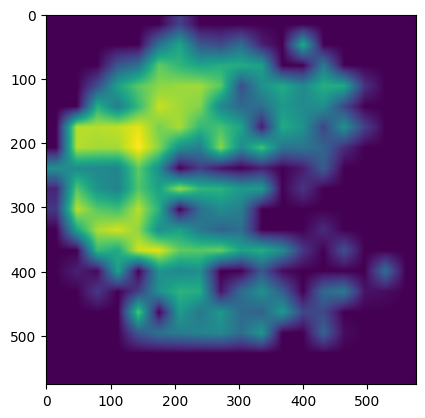

In [15]:
cam = output[0, :]
plt.imshow(cam)

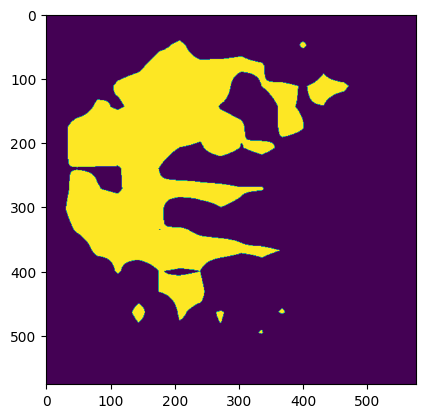

In [16]:
# get the thresholded map. as a default, the pixel contribution is determined as 0.5.
th, im_th = cv2.threshold(cam, thres, 1.0, cv2.THRESH_BINARY)
plt.imshow(im_th)

In [17]:
# load the segmented retinal regions by Automorph
img_seg_artery = Image.open(os.path.join("./data/classification_segmentation/M2/artery_vein/artery_binary_process", img_name))
img_seg_vein = Image.open(os.path.join("./data/classification_segmentation/M2/artery_vein/vein_binary_process", img_name))

In [18]:
# Resize the segmentation map and binarize it
img_seg_artery = img_seg_artery.resize((576,576))
img_seg_artery  = np.array(img_seg_artery)
th, img_seg_artery = cv2.threshold(img_seg_artery, 0.1, 1.0, cv2.THRESH_BINARY)
img_seg_artery = img_seg_artery.astype(np.float32)

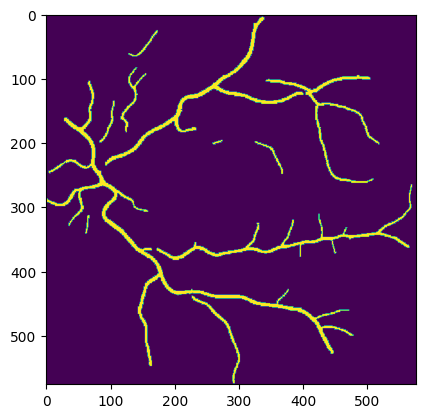

In [19]:
plt.imshow(img_seg_artery)

The percentage of artery used for the inference is 47.87%


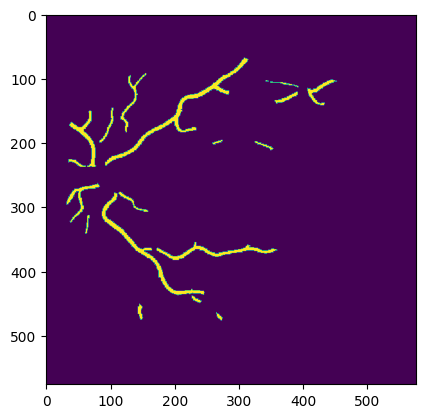

In [20]:
overlay_artery = img_seg_artery * im_th
plt.imshow(overlay_artery)
im = Image.fromarray(overlay_artery*255).convert('RGB')
print("The percentage of artery used for the inference is {:.2f}%".format(np.count_nonzero(overlay_artery)/np.count_nonzero(img_seg_artery)*100))
#im.save(img_name[:-4] + '_'+"Artery"+".jpeg")

In [21]:
img_seg_vein = img_seg_vein.resize((576,576))
img_seg_vein  = np.array(img_seg_vein)
th, img_seg_vein = cv2.threshold(img_seg_vein, 0.1, 1.0, cv2.THRESH_BINARY)
img_seg_vein = img_seg_vein.astype(np.float32)

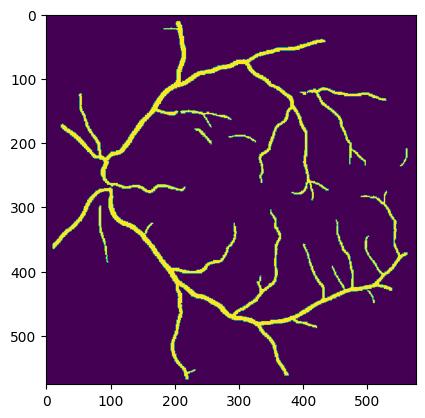

In [22]:
plt.imshow(img_seg_vein)

The percentage of vein used for the inference is 46.18%


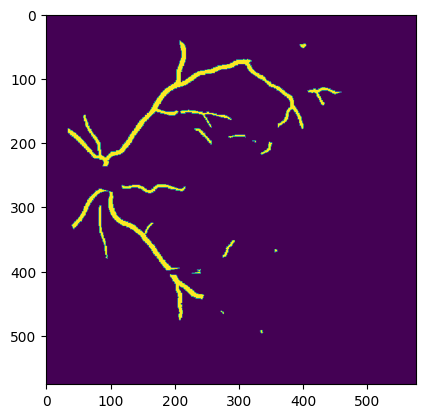

In [23]:
overlay_vein = img_seg_vein * im_th
plt.imshow(overlay_vein)
im = Image.fromarray(overlay_vein*255).convert('RGB')
print("The percentage of vein used for the inference is {:.2f}%".format(np.count_nonzero(overlay_vein)/np.count_nonzero(img_seg_vein)*100))
#im.save(img_name[:-4] +"_"+"Vein"+".jpeg")

In [24]:
img_seg_optic_disc_cup = Image.open(os.path.join("./data/classification_segmentation/M2/optic_disc_cup/raw", img_name))

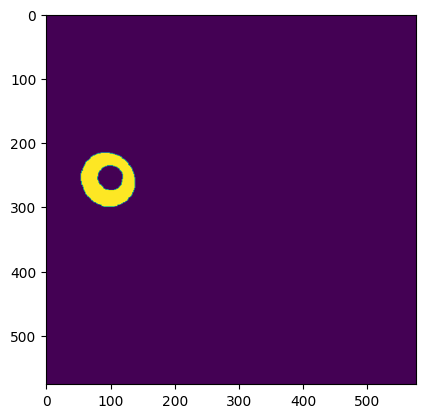

In [25]:
img_seg_optic_disc_cup = img_seg_optic_disc_cup.resize((576,576))
img_seg_optic_disc_cup  = np.array(img_seg_optic_disc_cup)
img_seg_optic_disc_cup = img_seg_optic_disc_cup.astype(np.float32)
img_seg_optic_disc_cup = img_seg_optic_disc_cup/255
img_seg_optic_disc_cup = img_seg_optic_disc_cup.astype(np.float32)

img_seg_optic_disc = img_seg_optic_disc_cup[:, :, 0]
plt.imshow(img_seg_optic_disc)

The percentage of disc used for the inference is 87.14%


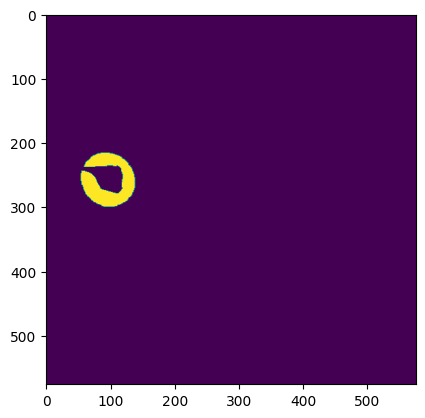

In [26]:
overlay_optic_disc = img_seg_optic_disc * im_th
plt.imshow(overlay_optic_disc)
im = Image.fromarray(overlay_optic_disc*255).convert('RGB')
print("The percentage of disc used for the inference is {:.2f}%".format(np.count_nonzero(overlay_optic_disc)/np.count_nonzero(img_seg_optic_disc)*100))
#im.save(img_name[:-4] +"_"+"Disc"+".jpeg")

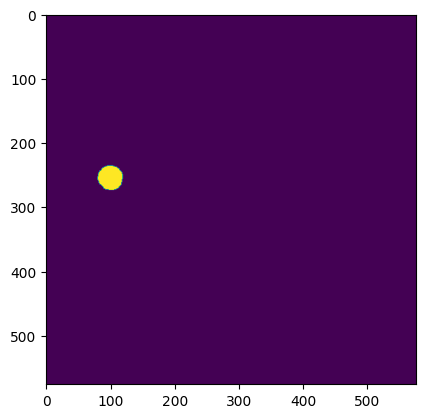

In [27]:
img_seg_optic_cup = img_seg_optic_disc_cup[:, :, 2]
plt.imshow(img_seg_optic_cup)

The percentage of cup used for the inference is 4.76%


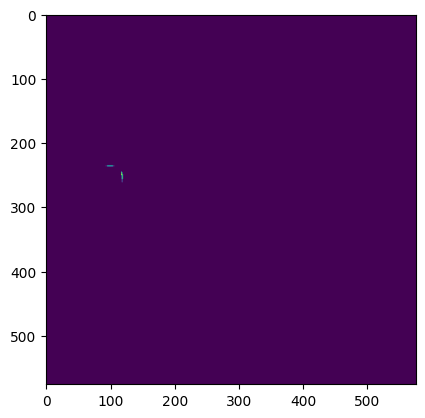

In [28]:
overlay_optic_cup = img_seg_optic_cup * im_th
plt.imshow(overlay_optic_cup)
im = Image.fromarray(overlay_optic_cup*255).convert('RGB')
print("The percentage of cup used for the inference is {:.2f}%".format(np.count_nonzero(overlay_optic_cup)/np.count_nonzero(img_seg_optic_cup)*100))
#im.save(img_name[:-4] +"_"+"Cup"+".jpeg")